# YOLO v3
In this notebook, we will go through [a YOLO v3 PyTorch implementation](https://github.com/eriklindernoren/PyTorch-YOLOv3) and learn how YOLO v3 is actually implemented in code.

![yolo](https://blog.paperspace.com/content/images/size/w2000/2018/04/maxresdefault-p1.jpg)

Credit for the explanation in this notebook is due to this [post](https://blog.paperspace.com/how-to-implement-a-yolo-object-detector-in-pytorch/).

# 1. Overall Architecture
YOLO makes use of only convolutional layers, making it **a fully convolutional network (FCN)**. It has 75 convolutional layers, with skip connections and upsampling layers. No form of pooling is used, and a convolutional layer with stride 2 is used to downsample the feature maps. This helps in preventing loss of low-level features often attributed to pooling.

The network downsamples the image by a factor called the stride of the network. For example, if the stride of the network is 32, then an input image of size 416 x 416 will yield an output of size 13 x 13.

# 2. Output of the network

![dog](https://blog.paperspace.com/content/images/2018/04/yolo-5.png)

Depth-wise, we have **(B x (5 + C)) entries in the feature map**. B represents the number of bounding boxes each cell can predict. According to the paper, each of these B bounding boxes may specialize in detecting a certain kind of object. Each of the bounding boxes have 5 + C attributes, which describe the center coordinates, the dimensions, the objectness score and C class confidences for each bounding box. YOLO v3 predicts 3 bounding boxes for every cell.

You expect **each cell of the feature map to predict an object** through one of it's bounding boxes **if the center of the object falls in the receptive field of that cell**. (Receptive field is the region of the input image visible to the cell. Refer to the link on convolutional neural networks for further clarification).

# 3. Details of the Predictions
The following formulae describe how the network output is transformed to obtain bounding box predictions.

## YOLO Equations
bx, by, bw, bh are the x,y center co-ordinates, width and height of our prediction. tx, ty, tw, th is what the network outputs. cx and cy are the top-left co-ordinates of the grid. pw and ph are anchors dimensions for the box.

![box coordinates](https://blog.paperspace.com/content/images/2018/04/Screen-Shot-2018-04-10-at-3.18.08-PM.png)

## Center Coordinates
Notice we are running our center coordinates prediction through a sigmoid function. This forces the value of the output to be between 0 and 1. Why should this be the case? Bear with me.

Normally, YOLO doesn't predict the absolute coordinates of the bounding box's center. It predicts offsets which are:

Relative to the top left corner of the grid cell which is predicting the object.

Normalised by the dimensions of the cell from the feature map, which is, 1.

For example, consider the case of our dog image. If the prediction for center is (0.4, 0.7), then this means that the center lies at (6.4, 6.7) on the 13 x 13 feature map. (Since the top-left co-ordinates of the red cell are (6,6)).

But wait, what happens if the predicted x,y co-ordinates are greater than one, say (1.2, 0.7). This means center lies at (7.2, 6.7). Notice the center now lies in cell just right to our red cell, or the 8th cell in the 7th row. This breaks theory behind YOLO because if we postulate that the red box is responsible for predicting the dog, the center of the dog must lie in the red cell, and not in the one beside it.

Therefore, to remedy this problem, the output is passed through a sigmoid function, which squashes the output in a range from 0 to 1, effectively keeping the center in the grid which is predicting.

## Dimensions of the Bounding Box

![dimsof](https://blog.paperspace.com/content/images/2018/04/yolo-regression-1.png)

The dimensions of the bounding box are predicted by applying a log-space transform to the output and then multiplying with an anchor.

How the detector output is transformed to give the final prediction. Image Credits. http://christopher5106.github.io/

The resultant predictions, bw and bh, are normalised by the height and width of the image. (Training labels are chosen this way). So, if the predictions bx and by for the box containing the dog are (0.3, 0.8), then the actual width and height on 13 x 13 feature map is (13 x 0.3, 13 x 0.8).

## Objectness Score
Object score represents the probability that an object is contained inside a bounding box. It should be nearly 1 for the red and the neighboring grids, whereas almost 0 for, say, the grid at the corners.

The objectness score is also passed through a sigmoid, as it is to be interpreted as a probability.

## Class Confidences
Class confidences represent the probabilities of the detected object belonging to a particular class (Dog, cat, banana, car etc). Before v3, YOLO used to softmax the class scores.

However, that design choice has been dropped in v3, and authors have opted for using sigmoid instead. The reason is that Softmaxing class scores assume that the classes are mutually exclusive. In simple words, if an object belongs to one class, then it's guaranteed it cannot belong to another class. This is true for COCO database on which we will base our detector.

# 4. Prediction across different scales.

![scales](https://blog.paperspace.com/content/images/2018/04/yolo_Scales-1.png)

**YOLO v3 makes prediction across 3 different scales.** The detection layer is used make detection at feature maps of three different sizes, having strides 32, 16, 8 respectively. This means, with an input of 416 x 416, we **make detections on scales 13 x 13, 26 x 26 and 52 x 52**.

The network downsamples the input image until the first detection layer, where **a detection is made using feature maps of a layer with stride 32**. Further, layers are **upsampled by a factor of 2 and concatenated with feature maps of a previous layers** having identical feature map sizes. Another detection is now made at layer with stride 16. The same upsampling procedure is repeated, and a final detection is made at the layer of stride 8.

At each scale, **each cell predicts 3 bounding boxes using 3 anchors, making the total number of anchors used 9**. (The anchors are different for different scales)

# 5. Output Processing
For an image of size 416 x 416, YOLO predicts ((52 x 52) + (26 x 26) + 13 x 13)) x 3 = 10647 bounding boxes. However, in case of our image, there's only one object, a dog. How do we reduce the detections from 10647 to 1?

### 1. Thresholding by Object Confidence
First, we filter boxes based on their objectness score. Generally, boxes having scores below a threshold are ignored.

### 2. Non-maximum Suppression (NMS)
![nms](https://blog.paperspace.com/content/images/2018/04/NMS-1.png)

NMS intends to cure the problem of multiple detections of the same image. For example, all the 3 bounding boxes of the red grid cell may detect a box or the adjacent cells may detect the same object.

# Download the codebase

In [1]:
!git clone https://github.com/eriklindernoren/PyTorch-YOLOv3
!cd PyTorch-YOLOv3 && git checkout 83c3d
!cd ..
!cp -r PyTorch-YOLOv3/* .
!rm -rf PyTorch-YOLOv3/

Cloning into 'PyTorch-YOLOv3'...
Note: switching to '83c3d'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 83c3d8b Testing for different batch_size.
'cp'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.
'rm'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [2]:
!cd weights && bash download_weights.sh

# Downloading COCO dataset takes about 5 hours.
# !cd data && bash get_coco_dataset.sh

������ ��θ� ã�� �� �����ϴ�.


# Imports

In [4]:
import os
import sys
import time
import datetime
import argparse

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import torch.optim as optim

from utils.logger import *
from utils.datasets import *
from utils.parse_config import *
from utils.utils import *

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import NullLocator

ModuleNotFoundError: No module named 'utils.logger'

# YOLO Layers

In [8]:
class YOLOLayer(nn.Module):
    """Detection layer"""

    def __init__(self, anchors, num_classes, img_dim=416):
        super(YOLOLayer, self).__init__()
        self.anchors = anchors
        self.num_anchors = len(anchors)
        self.num_classes = num_classes
        self.ignore_thres = 0.5
        self.mse_loss = nn.MSELoss()
        self.bce_loss = nn.BCELoss()
        self.obj_scale = 1
        self.noobj_scale = 100
        self.metrics = {}
        self.img_dim = img_dim
        self.grid_size = 0  # grid size

    def compute_grid_offsets(self, grid_size, cuda=True):
        self.grid_size = grid_size
        g = self.grid_size
        FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
        self.stride = self.img_dim / self.grid_size
        # Calculate offsets for each grid
        self.grid_x = torch.arange(g).repeat(g, 1).view([1, 1, g, g]).type(FloatTensor) 
        self.grid_y = torch.arange(g).repeat(g, 1).t().view([1, 1, g, g]).type(FloatTensor)
        self.scaled_anchors = FloatTensor([(a_w / self.stride, a_h / self.stride) for a_w, a_h in self.anchors])
        self.anchor_w = self.scaled_anchors[:, 0:1].view((1, self.num_anchors, 1, 1))
        self.anchor_h = self.scaled_anchors[:, 1:2].view((1, self.num_anchors, 1, 1))

    def forward(self, x, targets=None, img_dim=None):
        # Tensors for cuda support
        FloatTensor = torch.cuda.FloatTensor if x.is_cuda else torch.FloatTensor
        LongTensor = torch.cuda.LongTensor if x.is_cuda else torch.LongTensor
        ByteTensor = torch.cuda.ByteTensor if x.is_cuda else torch.ByteTensor

        self.img_dim = img_dim
        num_samples = x.size(0)
        grid_size = x.size(2)

        prediction = (
            # reshape to BATCH x B x (C + 5) x F x F
            x.view(num_samples, self.num_anchors, self.num_classes + 5, grid_size, grid_size)
            .permute(0, 1, 3, 4, 2)
            .contiguous()
        )

        x = torch.sigmoid(prediction[..., 0])  # Center x
        y = torch.sigmoid(prediction[..., 1])  # Center y
        w = prediction[..., 2]  # Width
        h = prediction[..., 3]  # Height

        pred_conf = torch.sigmoid(prediction[..., 4])  # Conf
        pred_cls = torch.sigmoid(prediction[..., 5:])  # Cls pred.

        # If grid size does not match current we compute new offsets
        if grid_size != self.grid_size:
            self.compute_grid_offsets(grid_size, cuda=x.is_cuda)

        # Add offset and scale with anchors
        pred_boxes = FloatTensor(prediction[..., :4].shape)
        pred_boxes[..., 0] = x.data + self.grid_x
        pred_boxes[..., 1] = y.data + self.grid_y
        pred_boxes[..., 2] = torch.exp(w.data) * self.anchor_w
        pred_boxes[..., 3] = torch.exp(h.data) * self.anchor_h

        output = torch.cat(
            (
                pred_boxes.view(num_samples, -1, 4) * self.stride,
                pred_conf.view(num_samples, -1, 1),
                pred_cls.view(num_samples, -1, self.num_classes),
            ),
            -1,
        )

        if targets is None:
            return output, 0
        else:
            iou_scores, class_mask, obj_mask, noobj_mask, tx, ty, tw, th, tcls, tconf = build_targets(
                pred_boxes=pred_boxes,
                pred_cls=pred_cls,
                target=targets,
                anchors=self.scaled_anchors,
                ignore_thres=self.ignore_thres,
            )

            # Loss : Mask outputs to ignore non-existing objects (except with conf. loss)
            loss_x = self.mse_loss(x[obj_mask], tx[obj_mask])
            loss_y = self.mse_loss(y[obj_mask], ty[obj_mask])
            loss_w = self.mse_loss(w[obj_mask], tw[obj_mask])
            loss_h = self.mse_loss(h[obj_mask], th[obj_mask])
            loss_conf_obj = self.bce_loss(pred_conf[obj_mask], tconf[obj_mask])
            loss_conf_noobj = self.bce_loss(pred_conf[noobj_mask], tconf[noobj_mask])
            loss_conf = self.obj_scale * loss_conf_obj + self.noobj_scale * loss_conf_noobj
            loss_cls = self.bce_loss(pred_cls[obj_mask], tcls[obj_mask])
            total_loss = loss_x + loss_y + loss_w + loss_h + loss_conf + loss_cls

            # Metrics
            cls_acc = 100 * class_mask[obj_mask].mean()
            conf_obj = pred_conf[obj_mask].mean()
            conf_noobj = pred_conf[noobj_mask].mean()
            conf50 = (pred_conf > 0.5).float()
            iou50 = (iou_scores > 0.5).float()
            iou75 = (iou_scores > 0.75).float()
            detected_mask = conf50 * class_mask * tconf
            precision = torch.sum(iou50 * detected_mask) / (conf50.sum() + 1e-16)
            recall50 = torch.sum(iou50 * detected_mask) / (obj_mask.sum() + 1e-16)
            recall75 = torch.sum(iou75 * detected_mask) / (obj_mask.sum() + 1e-16)

            self.metrics = {
                "loss": to_cpu(total_loss).item(),
                "x": to_cpu(loss_x).item(),
                "y": to_cpu(loss_y).item(),
                "w": to_cpu(loss_w).item(),
                "h": to_cpu(loss_h).item(),
                "conf": to_cpu(loss_conf).item(),
                "cls": to_cpu(loss_cls).item(),
                "cls_acc": to_cpu(cls_acc).item(),
                "recall50": to_cpu(recall50).item(),
                "recall75": to_cpu(recall75).item(),
                "precision": to_cpu(precision).item(),
                "conf_obj": to_cpu(conf_obj).item(),
                "conf_noobj": to_cpu(conf_noobj).item(),
                "grid_size": grid_size,
            }

            return output, total_loss


class Upsample(nn.Module):
    """ nn.Upsample is deprecated """

    def __init__(self, scale_factor, mode="nearest"):
        super(Upsample, self).__init__()
        self.scale_factor = scale_factor
        self.mode = mode

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        return x

#nn.Identity
class EmptyLayer(nn.Module):
    """Placeholder for 'route' and 'shortcut' layers"""

    def __init__(self):
        super(EmptyLayer, self).__init__()

# Architecture Config Reader

In [4]:
!cat config/yolov3.cfg

[net]
# Testing
#batch=1
#subdivisions=1
# Training
batch=16
subdivisions=1
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = 500200
policy=steps
steps=400000,450000
scales=.1,.1

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

# Downsample

[convolutional]
batch_normalize=1
filters=64
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=32
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

# Downsample

[convolutional]
batch_normalize=1
filters=128
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

[convolutional]


In [5]:
def create_modules(module_defs):
    """
    Constructs module list of layer blocks from module configuration in module_defs
    """
    hyperparams = module_defs.pop(0)
    output_filters = [int(hyperparams["channels"])]
    module_list = nn.ModuleList()
    for module_i, module_def in enumerate(module_defs):
        modules = nn.Sequential()

        if module_def["type"] == "convolutional":
            bn = int(module_def["batch_normalize"])
            filters = int(module_def["filters"])
            kernel_size = int(module_def["size"])
            pad = (kernel_size - 1) // 2
            modules.add_module(
                f"conv_{module_i}",
                nn.Conv2d(
                    in_channels=output_filters[-1],
                    out_channels=filters,
                    kernel_size=kernel_size,
                    stride=int(module_def["stride"]),
                    padding=pad,
                    bias=not bn,
                ),
            )
            if bn:
                modules.add_module(f"batch_norm_{module_i}", nn.BatchNorm2d(filters, momentum=0.9, eps=1e-5))
            if module_def["activation"] == "leaky":
                modules.add_module(f"leaky_{module_i}", nn.LeakyReLU(0.1))

        elif module_def["type"] == "maxpool":
            kernel_size = int(module_def["size"])
            stride = int(module_def["stride"])
            if kernel_size == 2 and stride == 1:
                modules.add_module(f"_debug_padding_{module_i}", nn.ZeroPad2d((0, 1, 0, 1)))
            maxpool = nn.MaxPool2d(kernel_size=kernel_size, stride=stride, padding=int((kernel_size - 1) // 2))
            modules.add_module(f"maxpool_{module_i}", maxpool)

        elif module_def["type"] == "upsample":
            upsample = Upsample(scale_factor=int(module_def["stride"]), mode="nearest")
            modules.add_module(f"upsample_{module_i}", upsample)

        elif module_def["type"] == "route":
            layers = [int(x) for x in module_def["layers"].split(",")]
            filters = sum([output_filters[1:][i] for i in layers])
            modules.add_module(f"route_{module_i}", EmptyLayer())

        elif module_def["type"] == "shortcut":
            filters = output_filters[1:][int(module_def["from"])]
            modules.add_module(f"shortcut_{module_i}", EmptyLayer())

        elif module_def["type"] == "yolo":
            anchor_idxs = [int(x) for x in module_def["mask"].split(",")]
            # Extract anchors
            anchors = [int(x) for x in module_def["anchors"].split(",")]
            anchors = [(anchors[i], anchors[i + 1]) for i in range(0, len(anchors), 2)]
            anchors = [anchors[i] for i in anchor_idxs]
            num_classes = int(module_def["classes"])
            img_size = int(hyperparams["height"])
            # Define detection layer
            yolo_layer = YOLOLayer(anchors, num_classes, img_size)
            modules.add_module(f"yolo_{module_i}", yolo_layer)
        # Register module list and number of output filters
        module_list.append(modules)
        output_filters.append(filters)

    return hyperparams, module_list

# YOLOv3 Model

In [6]:
class Darknet(nn.Module):
    """YOLOv3 object detection model"""

    def __init__(self, config_path, img_size=416):
        super(Darknet, self).__init__()
        self.module_defs = parse_model_config(config_path)
        self.hyperparams, self.module_list = create_modules(self.module_defs)
        self.yolo_layers = [layer[0] for layer in self.module_list if hasattr(layer[0], "metrics")]
        self.img_size = img_size
        self.seen = 0
        self.header_info = np.array([0, 0, 0, self.seen, 0], dtype=np.int32)

    def forward(self, x, targets=None):
        img_dim = x.shape[2]
        loss = 0
        layer_outputs, yolo_outputs = [], []
        for i, (module_def, module) in enumerate(zip(self.module_defs, self.module_list)):
            if module_def["type"] in ["convolutional", "upsample", "maxpool"]:
                x = module(x)
            elif module_def["type"] == "route":
                x = torch.cat([layer_outputs[int(layer_i)] for layer_i in module_def["layers"].split(",")], 1)
            elif module_def["type"] == "shortcut":
                layer_i = int(module_def["from"])
                x = layer_outputs[-1] + layer_outputs[layer_i]
            elif module_def["type"] == "yolo":
                x, layer_loss = module[0](x, targets, img_dim)
                loss += layer_loss
                yolo_outputs.append(x)
            layer_outputs.append(x)
        yolo_outputs = to_cpu(torch.cat(yolo_outputs, 1))
        return yolo_outputs if targets is None else (loss, yolo_outputs)

    def load_darknet_weights(self, weights_path):
        """Parses and loads the weights stored in 'weights_path'"""

        # Open the weights file
        with open(weights_path, "rb") as f:
            header = np.fromfile(f, dtype=np.int32, count=5)  # First five are header values
            self.header_info = header  # Needed to write header when saving weights
            self.seen = header[3]  # number of images seen during training
            weights = np.fromfile(f, dtype=np.float32)  # The rest are weights

        # Establish cutoff for loading backbone weights
        cutoff = None
        if "darknet53.conv.74" in weights_path:
            cutoff = 75

        ptr = 0
        for i, (module_def, module) in enumerate(zip(self.module_defs, self.module_list)):
            if i == cutoff:
                break
            if module_def["type"] == "convolutional":
                conv_layer = module[0]
                if module_def["batch_normalize"]:
                    # Load BN bias, weights, running mean and running variance
                    bn_layer = module[1]
                    num_b = bn_layer.bias.numel()  # Number of biases
                    # Bias
                    bn_b = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(bn_layer.bias)
                    bn_layer.bias.data.copy_(bn_b)
                    ptr += num_b
                    # Weight
                    bn_w = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(bn_layer.weight)
                    bn_layer.weight.data.copy_(bn_w)
                    ptr += num_b
                    # Running Mean
                    bn_rm = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(bn_layer.running_mean)
                    bn_layer.running_mean.data.copy_(bn_rm)
                    ptr += num_b
                    # Running Var
                    bn_rv = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(bn_layer.running_var)
                    bn_layer.running_var.data.copy_(bn_rv)
                    ptr += num_b
                else:
                    # Load conv. bias
                    num_b = conv_layer.bias.numel()
                    conv_b = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(conv_layer.bias)
                    conv_layer.bias.data.copy_(conv_b)
                    ptr += num_b
                # Load conv. weights
                num_w = conv_layer.weight.numel()
                conv_w = torch.from_numpy(weights[ptr : ptr + num_w]).view_as(conv_layer.weight)
                conv_layer.weight.data.copy_(conv_w)
                ptr += num_w

    def save_darknet_weights(self, path, cutoff=-1):
        """
            @:param path    - path of the new weights file
            @:param cutoff  - save layers between 0 and cutoff (cutoff = -1 -> all are saved)
        """
        fp = open(path, "wb")
        self.header_info[3] = self.seen
        self.header_info.tofile(fp)

        # Iterate through layers
        for i, (module_def, module) in enumerate(zip(self.module_defs[:cutoff], self.module_list[:cutoff])):
            if module_def["type"] == "convolutional":
                conv_layer = module[0]
                # If batch norm, load bn first
                if module_def["batch_normalize"]:
                    bn_layer = module[1]
                    bn_layer.bias.data.cpu().numpy().tofile(fp)
                    bn_layer.weight.data.cpu().numpy().tofile(fp)
                    bn_layer.running_mean.data.cpu().numpy().tofile(fp)
                    bn_layer.running_var.data.cpu().numpy().tofile(fp)
                # Load conv bias
                else:
                    conv_layer.bias.data.cpu().numpy().tofile(fp)
                # Load conv weights
                conv_layer.weight.data.cpu().numpy().tofile(fp)

        fp.close()

# Training (Optional)

In [ ]:
import sys
sys.argv=['']
del sys

import tensorflow as tf


parser = argparse.ArgumentParser()
parser.add_argument("--epochs", type=int, default=100, help="number of epochs")
parser.add_argument("--batch_size", type=int, default=8, help="size of each image batch")
parser.add_argument("--gradient_accumulations", type=int, default=2, help="number of gradient accums before step")
parser.add_argument("--model_def", type=str, default="config/yolov3.cfg", help="path to model definition file")
parser.add_argument("--data_config", type=str, default="config/coco.data", help="path to data config file")
parser.add_argument("--pretrained_weights", type=str, help="if specified starts from checkpoint model")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--img_size", type=int, default=416, help="size of each image dimension")
parser.add_argument("--checkpoint_interval", type=int, default=1, help="interval between saving model weights")
parser.add_argument("--evaluation_interval", type=int, default=1, help="interval evaluations on validation set")
parser.add_argument("--compute_map", default=False, help="if True computes mAP every tenth batch")
parser.add_argument("--multiscale_training", default=True, help="allow for multi-scale training")
opt = parser.parse_args()
print(opt)

logger = tf.summary.create_file_writer('logs')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.makedirs("output", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)

# Get data configuration
data_config = parse_data_config(opt.data_config)
train_path = data_config["train"]
valid_path = data_config["valid"]
class_names = load_classes(data_config["names"])

# Initiate model
model = Darknet(opt.model_def).to(device)
model.apply(weights_init_normal)

# If specified we start from checkpoint
if opt.pretrained_weights:
    if opt.pretrained_weights.endswith(".pth"):
        model.load_state_dict(torch.load("./data/best_model.pth"))
    else:
        model.load_darknet_weights(opt.pretrained_weights)

# Get dataloader
dataset = ListDataset(train_path, augment=True, multiscale=opt.multiscale_training)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=opt.batch_size,
    shuffle=True,
    num_workers=opt.n_cpu,
    pin_memory=True,
    collate_fn=dataset.collate_fn,
)

optimizer = torch.optim.Adam(model.parameters())

metrics = [
    "grid_size",
    "loss",
    "x",
    "y",
    "w",
    "h",
    "conf",
    "cls",
    "cls_acc",
    "recall50",
    "recall75",
    "precision",
    "conf_obj",
    "conf_noobj",
]

for epoch in range(opt.epochs):
    model.train()
    start_time = time.time()
    for batch_i, (_, imgs, targets) in enumerate(dataloader):
        batches_done = len(dataloader) * epoch + batch_i

        imgs = Variable(imgs.to(device))
        targets = Variable(targets.to(device), requires_grad=False)

        loss, outputs = model(imgs, targets)
        loss.backward()

        if batches_done % opt.gradient_accumulations:
            # Accumulates gradient before each step
            optimizer.step()
            optimizer.zero_grad()

        # ----------------
        #   Log progress
        # ----------------

        log_str = "\n---- [Epoch %d/%d, Batch %d/%d] ----\n" % (epoch, opt.epochs, batch_i, len(dataloader))

        metric_table = [["Metrics", *[f"YOLO Layer {i}" for i in range(len(model.yolo_layers))]]]

        # Log metrics at each YOLO layer
        for i, metric in enumerate(metrics):
            formats = {m: "%.6f" for m in metrics}
            formats["grid_size"] = "%2d"
            formats["cls_acc"] = "%.2f%%"
            row_metrics = [formats[metric] % yolo.metrics.get(metric, 0) for yolo in model.yolo_layers]
            metric_table += [[metric, *row_metrics]]

            # Tensorboard logging
            tensorboard_log = []
            for j, yolo in enumerate(model.yolo_layers):
                for name, metric in yolo.metrics.items():
                    if name != "grid_size":
                        tensorboard_log += [(f"{name}_{j+1}", metric)]
            tensorboard_log += [("loss", loss.item())]
            # logger.list_of_scalars_summary(tensorboard_log, batches_done)

        log_str += AsciiTable(metric_table).table
        log_str += f"\nTotal loss {loss.item()}"

        # Determine approximate time left for epoch
        epoch_batches_left = len(dataloader) - (batch_i + 1)
        time_left = datetime.timedelta(seconds=epoch_batches_left * (time.time() - start_time) / (batch_i + 1))
        log_str += f"\n---- ETA {time_left}"

        print(log_str)

        model.seen += imgs.size(0)

    if epoch % opt.evaluation_interval == 0:
        print("\n---- Evaluating Model ----")
        # Evaluate the model on the validation set
        precision, recall, AP, f1, ap_class = evaluate(
            model,
            path=valid_path,
            iou_thres=0.5,
            conf_thres=0.5,
            nms_thres=0.5,
            img_size=opt.img_size,
            batch_size=8,
        )
        evaluation_metrics = [
            ("val_precision", precision.mean()),
            ("val_recall", recall.mean()),
            ("val_mAP", AP.mean()),
            ("val_f1", f1.mean()),
        ]
        # logger.list_of_scalars_summary(evaluation_metrics, epoch)

        # Print class APs and mAP
        ap_table = [["Index", "Class name", "AP"]]
        for i, c in enumerate(ap_class):
            ap_table += [[c, class_names[c], "%.5f" % AP[i]]]
        print(AsciiTable(ap_table).table)
        print(f"---- mAP {AP.mean()}")

    if epoch % opt.checkpoint_interval == 0:
        torch.save(model.state_dict(), f"checkpoints/yolov3_ckpt_%d.pth" % epoch)


# Test the YOLOv3


Performing object detection:
	+ Batch 0, Inference Time: 0:00:00.429123
	+ Batch 1, Inference Time: 0:00:00.064413
	+ Batch 2, Inference Time: 0:00:00.061049
	+ Batch 3, Inference Time: 0:00:00.060317
	+ Batch 4, Inference Time: 0:00:00.047406
	+ Batch 5, Inference Time: 0:00:00.063571
	+ Batch 6, Inference Time: 0:00:00.040506
	+ Batch 7, Inference Time: 0:00:00.040488
	+ Batch 8, Inference Time: 0:00:00.034690

Saving images:
(0) Image: 'data/samples/dog.jpg'
	+ Label: dog, Conf: 0.99335
	+ Label: bicycle, Conf: 0.99981
	+ Label: truck, Conf: 0.94229


<Figure size 432x288 with 0 Axes>

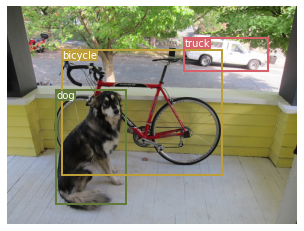

(1) Image: 'data/samples/eagle.jpg'
	+ Label: bird, Conf: 0.99703


<Figure size 432x288 with 0 Axes>

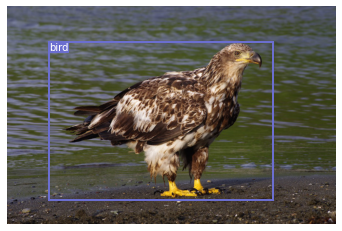

(2) Image: 'data/samples/field.jpg'
	+ Label: person, Conf: 0.99996
	+ Label: horse, Conf: 0.99977
	+ Label: dog, Conf: 0.99409


<Figure size 432x288 with 0 Axes>

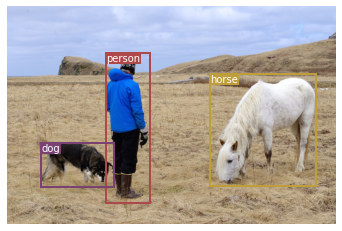

(3) Image: 'data/samples/giraffe.jpg'
	+ Label: giraffe, Conf: 0.99959
	+ Label: zebra, Conf: 0.97958


<Figure size 432x288 with 0 Axes>

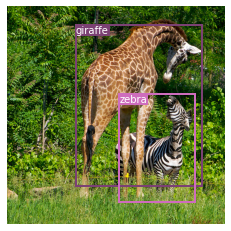

(4) Image: 'data/samples/herd_of_horses.jpg'
	+ Label: horse, Conf: 0.99459
	+ Label: horse, Conf: 0.99352
	+ Label: horse, Conf: 0.96845
	+ Label: horse, Conf: 0.99478


<Figure size 432x288 with 0 Axes>

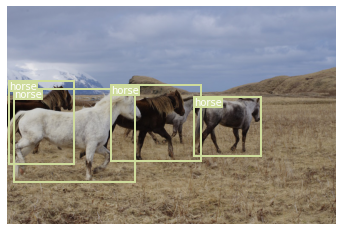

(5) Image: 'data/samples/messi.jpg'
	+ Label: person, Conf: 0.99993
	+ Label: person, Conf: 0.99984
	+ Label: person, Conf: 0.99996


<Figure size 432x288 with 0 Axes>

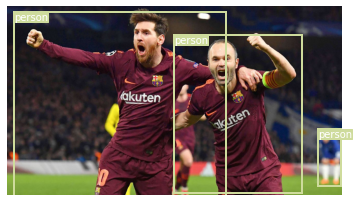

(6) Image: 'data/samples/person.jpg'
	+ Label: person, Conf: 0.99883
	+ Label: dog, Conf: 0.99275


<Figure size 432x288 with 0 Axes>

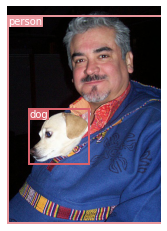

(7) Image: 'data/samples/room.jpg'
	+ Label: chair, Conf: 0.99906
	+ Label: chair, Conf: 0.96942
	+ Label: clock, Conf: 0.99971


<Figure size 432x288 with 0 Axes>

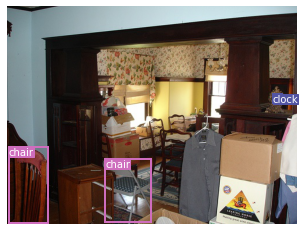

(8) Image: 'data/samples/street.jpg'
	+ Label: car, Conf: 0.99977
	+ Label: car, Conf: 0.99402
	+ Label: car, Conf: 0.99841
	+ Label: car, Conf: 0.99785
	+ Label: car, Conf: 0.97907
	+ Label: car, Conf: 0.95370
	+ Label: traffic light, Conf: 0.99995
	+ Label: car, Conf: 0.62254


<Figure size 432x288 with 0 Axes>

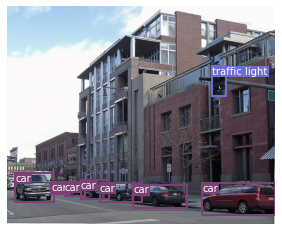

In [9]:
IMAGE_FOLDER = 'data/samples'
MODEL_DEF = 'config/yolov3.cfg'
WEIGHTS_PATH = 'weights/yolov3.weights'
CLASS_PATH = 'data/coco.names'
CONF_THRES = 0.8
NMS_THRES = 0.4
BATCH_SIZE = 1
N_CPU = 0
IMG_SIZE = 416
CHECKPOINT_MODEL = ''

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.makedirs("output", exist_ok=True)

# Set up model
model = Darknet(MODEL_DEF, img_size=IMG_SIZE).to(device)

if WEIGHTS_PATH.endswith(".weights"):
    # Load darknet weights
    model.load_darknet_weights(WEIGHTS_PATH)
else:
    # Load checkpoint weights
    model.load_state_dict(torch.load(WEIGHTS_PATH))

model.eval()  # Set in evaluation mode

dataloader = DataLoader(
    ImageFolder(IMAGE_FOLDER, img_size=IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=N_CPU,
)

classes = load_classes(CLASS_PATH)  # Extracts class labels from file

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

imgs = []  # Stores image paths
img_detections = []  # Stores detections for each image index

print("\nPerforming object detection:")
prev_time = time.time()
for batch_i, (img_paths, input_imgs) in enumerate(dataloader):
    # Configure input
    input_imgs = Variable(input_imgs.type(Tensor))

    # Get detections
    with torch.no_grad():
        detections = model(input_imgs)
        detections = non_max_suppression(detections, CONF_THRES, NMS_THRES)

    # Log progress
    current_time = time.time()
    inference_time = datetime.timedelta(seconds=current_time - prev_time)
    prev_time = current_time
    print("\t+ Batch %d, Inference Time: %s" % (batch_i, inference_time))

    # Save image and detections
    imgs.extend(img_paths)
    img_detections.extend(detections)

# Bounding-box colors
cmap = plt.get_cmap("tab20b")
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

print("\nSaving images:")
# Iterate through images and save plot of detections
for img_i, (path, detections) in enumerate(zip(imgs, img_detections)):

    print("(%d) Image: '%s'" % (img_i, path))

    # Create plot
    img = np.array(Image.open(path))
    plt.figure()
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    # Draw bounding boxes and labels of detections
    if detections is not None:
        # Rescale boxes to original image
        detections = rescale_boxes(detections, IMG_SIZE, img.shape[:2])
        unique_labels = detections[:, -1].cpu().unique()
        n_cls_preds = len(unique_labels)
        bbox_colors = random.sample(colors, n_cls_preds)
        for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:

            print("\t+ Label: %s, Conf: %.5f" % (classes[int(cls_pred)], cls_conf.item()))

            box_w = x2 - x1
            box_h = y2 - y1

            color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
            # Create a Rectangle patch
            bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none")
            # Add the bbox to the plot
            ax.add_patch(bbox)
            # Add label
            plt.text(
                x1,
                y1,
                s=classes[int(cls_pred)],
                color="white",
                verticalalignment="top",
                bbox={"color": color, "pad": 0},
            )

    # Save generated image with detections
    plt.axis("off")
    plt.gca().xaxis.set_major_locator(NullLocator())
    plt.gca().yaxis.set_major_locator(NullLocator())
    filename = path.split("/")[-1].split(".")[0]
    plt.savefig(f"output/{filename}.png", bbox_inches="tight", pad_inches=0.0)
    plt.show()
    plt.close()